In [5]:
import sys
sys.path.append("/home/wanxinli/EHR-OT/")

import matplotlib.pyplot as plt
from math import floor, ceil
from mimic_common import *
import numpy as np
import os
import pandas as pd
from scipy.stats import norm
import seaborn as sns
from statistics import median

In [6]:
def read_df(group_name, group_1, group_2, suffix = None):
    """ 
    Absoluate bound for filtering out ratios
    """
    target_equity_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{group_2}2{group_1}_equity.csv")
    if suffix is not None:
        target_equity_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{group_2}2{group_1}_{suffix}_equity.csv")
    target_equity_df = pd.read_csv(target_equity_path, header=0, index_col=None)

    target_diff_percents = target_equity_df['target_diff_percent']
    # target_diff_percents = [x for x in target_diff_percents if abs(x) < ratio_bound]

    return target_diff_percents

In [7]:
def plot_percents(group_name, group_1, group_2, diff_percent_1, proc_bias_1, diff_percent_2, proc_bias_2, ratio_bound = 10):
    """ 
    :param array diff_percent_1: error difference percent from group_1 to group_2
    :param array diff_percent_2: error difference percent from group_2 to group_1
    """
    bin_width = 0.1

    plt.subplot(1,2,1)
    plt.hist(diff_percent_1, bins=np.arange(-ratio_bound, \
                ratio_bound + bin_width, bin_width), density=True, alpha=0.5, label='transported target')
    plt.ylabel("Density")
    plt.xlabel("Ratio of difference between predicted \n duration and ground-truth duration")
    plt.ylim(0, 1)
    plt.title(f"Source: {group_1}, \n Target: {group_2}, \n Median: {round(proc_bias_1, 2)}")

    plt.legend()

    plt.subplot(1,2,2)
    plt.hist(diff_percent_2, bins=np.arange(-ratio_bound, \
                ratio_bound + bin_width, bin_width), density=True, alpha=0.5, label='transported target')
    plt.ylabel("Sensity")
    plt.xlabel("Ratio of difference between predicted \n duration and ground-truth duration")
    plt.ylim(0, 1)
    plt.title(f"Source: {group_2}, \n Target: {group_1}, \n Median: {round(proc_bias_2, 2)}")
    plt.legend()

    plt.tight_layout()

    save_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{group_2}_and_{group_1}_fairness.pdf")
    plt.savefig(save_path)
    plt.show()

In [8]:
def procedure_bias(target_diff_percents):
    """ 
    Quantifies the procedural bias between source error and target error
    Use median as the statistic

    :param list[float] source_diff_percents: (predicted value - ground truth value)/(ground truth value) for source 
    :param list[float] target_diff_percents: (transported predicted value - ground truth value)/(ground truth value) for target
    """
    
    # target_bias = ([True for i in target_diff_percents if i > 0].count(True))/len(target_diff_percents)
    # print(f"target bias is {target_bias}")
    # return target_bias
    # print("target_diff_percents is:", target_diff_percents)
    return median(target_diff_percents)

In [9]:
def entire_proc(group_name, group_1, group_2, ratio_bound = 10, plot=True):
    """ 
    Take the difference between two procedural bias as the final bias
    :param bool plot: generate histogram or not
    """
    
    target_diff_percent_1 = read_df(group_name, group_1, group_2)
    target_diff_percent_2 = read_df(group_name, group_2, group_1)
    proc_bias_1 = procedure_bias(target_diff_percent_1)
    proc_bias_2 = procedure_bias(target_diff_percent_2)
    
    if plot:
        plot_percents(group_name, group_1, group_2, target_diff_percent_1, \
                    proc_bias_1, target_diff_percent_2, proc_bias_2, ratio_bound)
    bias = proc_bias_1 - proc_bias_2
    if bias > 0:
        print(f"{group_1} > {group_2}")
    elif bias < 0:
        print(f"{group_2} > {group_1}")
    return bias

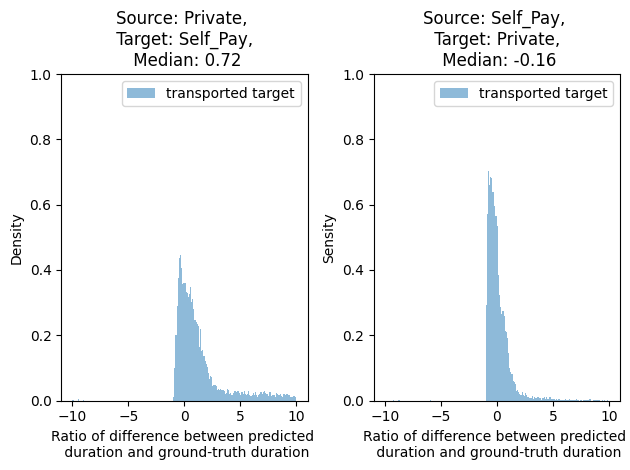

Private > Self_Pay


0.8801495364835376

In [10]:
# suffix = None
# group_name = 'marital_status'
# group_1 =  'MARRIED'
# group_2 = 'SINGLE'

suffix = None
group_name = 'insurance'
group_1 = 'Private'   
group_2 =  'Self_Pay'

# suffix = None
# group_name = 'gender'
# group_1 =  'F'
# group_2 = 'M'

# suffix = None
# group_name = 'ethnicity'
# group_1 =  'WHITE'
# # group_2 = 'HISPANIC_OR_LATINO'
# group_2 = 'ASIAN'

ratio_bound = 10

entire_proc(group_name, group_1, group_2, ratio_bound=ratio_bound)

In [13]:
# Make a correlation matrix between different subgroups 

def generate_corr_matrix(group_name, group_values):
    """ 
    Generate correlation matrix for subgroups 

    :param Dataframe equity_df: the dataframe storing equity scores 
    :param str group_name: the group name for dividing subgroups
    :param list[str] group_values: the group values for individual subgroups
    
    :returns: the correlation matrix
    """
    corr_matrix = np.zeros(shape=[len(group_values), len(group_values)])
    for i, group_value_1 in enumerate(group_values):
        for j, group_value_2 in enumerate(group_values):
            bias = 0
            if i != j:
                bias = entire_proc(group_name, group_value_1, group_value_2, plot=False)
            corr_matrix[i, j] = bias

    mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))
    df = pd.DataFrame(corr_matrix, index=group_values, columns=group_values)
    sns.heatmap(df, annot=True, mask=mask)


Private > Self_Pay
Government > Self_Pay
Medicare > Self_Pay
Medicaid > Self_Pay
Private > Self_Pay
Private > Government
Medicare > Private
Medicaid > Private
Government > Self_Pay
Private > Government
Medicare > Government
Medicaid > Government
Medicare > Self_Pay
Medicare > Private
Medicare > Government
Medicaid > Medicare
Medicaid > Self_Pay
Medicaid > Private
Medicaid > Government
Medicaid > Medicare


/tmp/ipykernel_2618377/634617450.py:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))


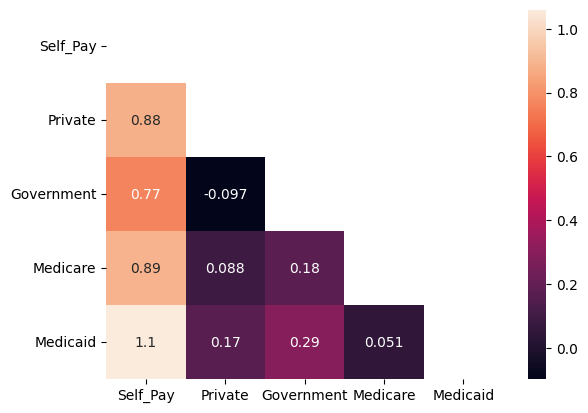

In [14]:
generate_corr_matrix('insurance', ['Self_Pay', 'Private', 'Government', 'Medicare', 'Medicaid'])

### topological sorting of all insurace: Medicaid > Medicare > Private > Government > Self Pay


MARRIED > SINGLE
MARRIED > WIDOWED
DIVORCED > MARRIED
SEPARATED > MARRIED
MARRIED > SINGLE
WIDOWED > SINGLE
DIVORCED > SINGLE
SEPARATED > SINGLE
MARRIED > WIDOWED
WIDOWED > SINGLE
DIVORCED > WIDOWED
SEPARATED > WIDOWED
DIVORCED > MARRIED
DIVORCED > SINGLE
DIVORCED > WIDOWED
SEPARATED > DIVORCED
SEPARATED > MARRIED
SEPARATED > SINGLE
SEPARATED > WIDOWED
SEPARATED > DIVORCED


/tmp/ipykernel_2618377/634617450.py:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))


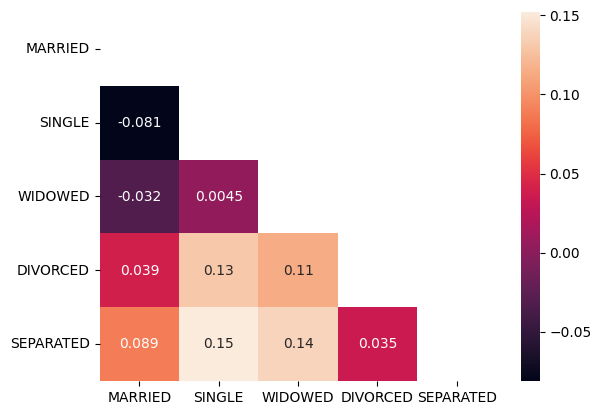

In [15]:
generate_corr_matrix('marital_status', ['MARRIED', 'SINGLE', 'WIDOWED', 'DIVORCED', 'SEPARATED'])

### topological sorting of all marital statuses: separated > divorced > married > widowed > single